In [1]:
import base64
from importlib import reload
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns
import shutil
import torch
from torch import distributions, nn
import torch.nn.functional as F
import time
import tqdm

# Custom imports
import graph_nns as gnn
import vectorized_env as ve
import vectorized_agents as va

%matplotlib inline
jtplot.style()

DEVICE = torch.device('cuda')
OBS_NORM = 100. / 1999.

## A3C RL algorithm

In [2]:
class A3CVectorized():
    def __init__(self, model_constructor, optimizer, model=None, device=torch.device('cuda'), exp_folder=Path('/home/isaiah/GitHub/Kaggle/Santa_2020/runs/TEMP'),
                 recurrent_model=False, clip_grads=10.,
                 play_against_past_selves=True, n_past_selves=4, checkpoint_freq=10, initial_opponent_pool=[], opp_posterior_decay=0.95):
        self.model_constructor = model_constructor
        self.optimizer = optimizer
        if model is None:
            self.model = self.model_constructor()
        else:
            self.model = model
        self.device = device
        self.exp_folder = exp_folder
        if str(self.exp_folder) == '/home/isaiah/GitHub/Kaggle/Santa_2020/runs/TEMP':
            print('WARNING: Using TEMP exp_folder')
            if self.exp_folder.exists():
                shutil.rmtree(self.exp_folder)
        elif self.exp_folder.exists() and any(Path(self.exp_folder).iterdir()):
            raise RuntimeError(f'Experiment folder {self.exp_folder} already exists and is not empty')
        else:
            print(f'Saving results to {self.exp_folder}')
        self.exp_folder.mkdir(exist_ok=True)
        self.recurrent_model = recurrent_model
        self.clip_grads = clip_grads
        self.play_against_past_selves = play_against_past_selves
        self.n_past_selves = n_past_selves
        self.checkpoint_freq = checkpoint_freq
        self.initial_opponent_pool = initial_opponent_pool
        self.opp_posterior_decay = opp_posterior_decay
        
        self.env = None
        self.opp_a = np.ones(len(self.initial_opponent_pool))
        self.opp_b = np.ones(len(self.initial_opponent_pool))
        self.checkpoints = []
        self.true_ep_num = 0
        
        if self.clip_grads is not None:
            assert self.clip_grads > 0, 'Should not clip gradients to 0 - pass None to clip_grads if gradient clipping should not be used'
            for p in self.model.parameters():
                if p.requires_grad:
                    p.register_hook(lambda grad: torch.clamp(grad, -self.clip_grads, self.clip_grads))
        
    def train(self, n_episodes, batch_size=30, gamma=0.99, **env_kwargs):
        if self.play_against_past_selves and 'opponent' in env_kwargs.keys():
            raise RuntimeError('Cannot play against past selves when opponent is defined')
        self.env = None
        self.model.train()
        episode_reward_sums = []
        
        for ep_num in tqdm.trange(n_episodes):
            if self.recurrent_model:
                self.model.reset_hidden_states()
            if self.play_against_past_selves:
                opponents, opponent_idxs = self.sample_opponents()
                self.env = ve.KaggleMABEnvTorchVectorized(opponent=opponents, **env_kwargs)
            else:
                self.env = ve.KaggleMABEnvTorchVectorized(**env_kwargs)
            buffer_a, buffer_r, buffer_l, buffer_v = [], [], [], []
            s, r, _, _ = self.env.reset()
            episode_reward_sums.append(r)
            step_count = 1
            a, (l, v) = self.model.sample_action(s.to(device=self.device).unsqueeze(0), train=True)
            while not self.env.done:
                next_s, r, done, _ = self.env.step(a.squeeze(0))

                buffer_a.append(a)
                buffer_r.append(r)
                buffer_l.append(l)
                buffer_v.append(v)

                if self.recurrent_model and (step_count % batch_size == 0 or done):
                    self.model.detach_hidden_states()
                a, (l, v) = self.model.sample_action(next_s.to(device=self.device).unsqueeze(0), train=True)
                
                if step_count % batch_size == 0 or done:
                    if done:
                        v_next_s = torch.zeros_like(buffer_r[-1])
                    else:
                        #_, v_next_s = self.model(next_s.to(device=self.device).unsqueeze(0))
                        v_next_s = v.detach().squeeze(0)
                    v_next_s.to(device=self.device)

                    buffer_v_target = []
                    for r in buffer_r[::-1]:
                        v_next_s = r + gamma * v_next_s
                        buffer_v_target.append(v_next_s)
                    buffer_v_target.reverse()
                    
                    actions = torch.cat(buffer_a).to(device=self.device)
                    v_t = torch.stack(buffer_v_target).to(device=self.device)
                    logits = torch.cat(buffer_l).to(device=self.device)
                    values = torch.cat(buffer_v).to(device=self.device)
                    #print(f'actions.shape: {actions.shape}, v_t.shape: {v_t.shape}')
                    
                    #print(f'logits.shape: {logits.shape}, values.shape: {values.shape}')
                    td = v_t - values
                    # Huber loss
                    critic_loss = F.smooth_l1_loss(v_t, values, reduction='none').view(-1)

                    probs = F.softmax(logits, dim=-1)
                    real_batch_size, n_envs, n_players, n_bandits = probs.shape
                    m = distributions.Categorical(probs.view(real_batch_size * n_envs * n_players, n_bandits))
                    #print(f'm.log_prob(actions.view(real_batch_size * n_envs * n_players)).shape: {m.log_prob(actions.view(real_batch_size * n_envs * n_players)).shape}, td.shape: {td.shape}')
                    actor_loss = -(m.log_prob(actions.view(-1)) * td.detach().view(-1))
                    total_loss = (critic_loss + actor_loss).mean()
                    
                    self.optimizer.zero_grad()
                    total_loss.backward()
                    self.optimizer.step()
                    buffer_a, buffer_r, buffer_l, buffer_v = [], [], [], []
                s = next_s
                episode_reward_sums[-1] += r
                step_count += 1
            if self.play_against_past_selves:
                if opponent_idxs is not None:
                    self.update_opponent_scores(opponent_idxs, self.env.player_rewards_sums.cpu())
                if ep_num % self.checkpoint_freq == 0:
                    self.checkpoint()
            if ep_num % self.checkpoint_freq == 0:
                self.save()
            episode_reward_sums[-1] = episode_reward_sums[-1].mean() / self.env.r_norm
            self.true_ep_num += 1
        self.save(finished=True)
        return episode_reward_sums
    
    def sample_opponents(self):
        if len(self.initial_opponent_pool) + len(self.checkpoints) == 0:
            print('No opponents sampled')
            return None, None
        else:
            opponents = []
            opponent_idxs = []
            for i in range(self.n_past_selves):
                # Sample opponents randomly if the agent is losing > some fraction of it's games, otherwise use thompson sampling
                if np.sum(self.opp_b - 1) <= np.sum(self.opp_a - 1) / 5.:
                    if i == 0:
                        print('Sampling opponents randomly')
                    selected_opp_idx = np.random.randint(len(self.opp_a))
                else:
                    if i == 0:
                        print('Sampling opponents using Thompson sampling')
                    selected_opp_idx = np.random.beta(self.opp_a, self.opp_b).argmax()
                opponent_idxs.append(selected_opp_idx)
                opponents.append(self.get_opponent(selected_opp_idx))
                if selected_opp_idx < len(self.initial_opponent_pool):
                    try:
                        print(f'Opponent {i}: {opponents[-1].name} with alpha {self.opp_a[selected_opp_idx]:.2f} and beta {self.opp_b[selected_opp_idx]:.2f}')
                    except AttributeError:
                        print(f'Opponent {i}: {opponents[-1]} with alpha {self.opp_a[selected_opp_idx]:.2f} and beta {self.opp_b[selected_opp_idx]:.2f}')
                else:
                    print(f'Opponent {i}: Checkpoint #{selected_opp_idx - len(self.initial_opponent_pool)} with alpha {self.opp_a[selected_opp_idx]:.2f} and beta {self.opp_b[selected_opp_idx]:.2f}')
            print()
            return va.MultiAgent(opponents), opponent_idxs

    def update_opponent_scores(self, curr_opp_idxs, player_rewards_sums):
        # player_rewards_sums.shape is (n_envs, n_players, n_bandits)
        # Decay posteriors
        self.opp_a = np.maximum(self.opp_a * self.opp_posterior_decay, 1.)
        self.opp_b = np.maximum(self.opp_b * self.opp_posterior_decay, 1.)
        
        # Update posteriors with new w/l stats
        rewards_sums = player_rewards_sums.sum(dim=2)
        game_scores = torch.zeros(rewards_sums.shape)
        winners_idxs = rewards_sums.argmax(dim=1)
        draws_mask = rewards_sums[:,0] == rewards_sums[:,1]
        game_scores[torch.arange(game_scores.shape[0]), winners_idxs] = 1.
        game_scores[draws_mask] = 0.5
        game_scores = [gs.numpy() for gs in game_scores.chunk(self.n_past_selves)]
        for match_idx, opp_idx in enumerate(curr_opp_idxs):
            self.opp_a[opp_idx] += game_scores[match_idx][:,1].sum()
            self.opp_b[opp_idx] += game_scores[match_idx][:,0].sum()
            
    def checkpoint(self):
        self.model.cpu()
        self.checkpoints.append(self.model.state_dict())
        self.opp_a = np.append(self.opp_a, 1.)
        self.opp_b = np.append(self.opp_b, 1.)
        self.model.to(device=self.device)
    
    def save(self, finished=False):
        if finished:
            file_path_base = self.exp_folder / f'final_{self.true_ep_num}'
        else:
            file_path_base = self.exp_folder / str(self.true_ep_num)
        # Save model params
        self.model.cpu()
        state_dict_bytes = pickle.dumps({
            'model_state_dict': self.model.state_dict(),
        })
        serialized_string = base64.b64encode(state_dict_bytes)
        with open(f'{file_path_base}_cp.txt', 'w') as f:
            f.write(str(serialized_string))
        self.model.to(device=self.device)
        # Save skill estimates
        if self.play_against_past_selves:
            checkpoint_idxs = np.arange(len(a3c_alg.opp_a)) - len(a3c_alg.initial_opponent_pool)
            checkpoint_idxs = np.where(
                checkpoint_idxs < 0,
                np.nan,
                checkpoint_idxs
            )
            df = pd.DataFrame({
                'opp_a': a3c_alg.opp_a,
                'opp_b': a3c_alg.opp_b,
                'est_opp_skill': a3c_alg.opp_a / (a3c_alg.opp_a + a3c_alg.opp_b),
                'checkpoint_idxs': checkpoint_idxs
            })
            df.to_csv(f'{file_path_base}_skill_estimates.csv')
    
    def get_opponent(self, idx):
        if idx < 0:
            raise IndexError(f'Negative indexing is not supported')
        elif idx < len(self.initial_opponent_pool):
            return self.initial_opponent_pool[idx]
        elif idx < len(self.initial_opponent_pool) + len(self.checkpoints):
            checkpoint_idx = idx - len(self.initial_opponent_pool)
            checkpoint_opp = self.model_constructor()
            checkpoint_opp.load_state_dict(self.checkpoints[checkpoint_idx])
            checkpoint_opp.to(device=self.device)
            checkpoint_opp.eval()
            return va.RLModelWrapperAgent(checkpoint_opp, self.obs_type)
        else:
            raise IndexError(f'Index {idx} is out of bounds')

## Optional: load a saved model state_dict from a serialized string file

In [3]:
#with open('rl_agents/ss_temp.txt', 'r') as f:
with open('runs/v4/cp_162.txt', 'r') as f:
    serialized_string = f.readline()[2:-1].encode()
state_dict_bytes = base64.b64decode(serialized_string)
loaded_state_dicts = pickle.loads(state_dict_bytes)

## RL training
#### TODO:
Change GNN layer option to "efficient_GNN"

Implement "fictitious self-play" to improve trained model robustness. On a related note, maybe compare trained agents against many/all agents from this notebook: https://www.kaggle.com/jamesmcguigan/santa-2020-agents-comparison

Implement new RL algorithm - AWAC, and use top team's logs as training data. See: https://www.kaggle.com/masatomatsui/santa-episode-scraper

Eventually, experiment with reward_type = END_OF_GAME

In [4]:
use_rnn = True

graph_nn_kwargs = dict(
    in_features=3,
    n_nodes=100,
    n_hidden_layers=3,
    layer_sizes=16,
    layer_class=gnn.SmallRecurrentGNNLayer if use_rnn else gnn.SmallFullyConnectedGNNLayer,
    skip_connection_n=1
)
model = gnn.GraphNNA3C(**graph_nn_kwargs)
try:
    sd = loaded_state_dicts['model_state_dict']
    model.load_state_dict(sd)
    print('Successfully loaded saved model')
    del loaded_state_dicts
except NameError:
    pass
except RuntimeError:
    print('WARNING: Failed to load saved model')
model.to(device=DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

env_kwargs = dict(
    n_envs=512,
    out_device=DEVICE,
    reward_type=ve.EVERY_STEP_EV,
    obs_type=ve.LAST_STEP_OBS if use_rnn else ve.SUMMED_OBS,
    opponent_obs_type=ve.SUMMED_OBS
)
rl_alg_kwargs = dict(
    batch_size=30 if use_rnn else 30,
    gamma=0.99
)

# Used for va.run_vectorized_vs
def model_wrapped(states):
    return model.sample_action(states.unsqueeze(0)).squeeze(0)

def model_constructor():
    return gnn.GraphNNA3C(**graph_nn_kwargs)

# initial_opponent_pool = []
initial_opponent_pool = [
    #va.BasicThompsonSampling(OBS_NORM),
    #va.PullVegasSlotMachines(OBS_NORM),
    #va.SavedRLAgent('a3c_agent_v0'),
    #va.SavedRLAgent('a3c_agent_v1'),
    #va.SavedRLAgent('a3c_agent_v2'),
    va.SavedRLAgent('a3c_agent_v3'),
]

a3c_alg = A3CVectorized(model_constructor, optimizer, model=model, device=DEVICE,
                        exp_folder=Path('/home/isaiah/GitHub/Kaggle/Santa_2020/runs/TEMP'),
                        recurrent_model=use_rnn,
                        clip_grads=10.,
                        play_against_past_selves=False,
                        n_past_selves=4,
                        checkpoint_freq=10,
                        initial_opponent_pool=initial_opponent_pool,
                        opp_posterior_decay=0.95)

100%|██████████| 30/30 [09:43<00:00, 19.46s/it]


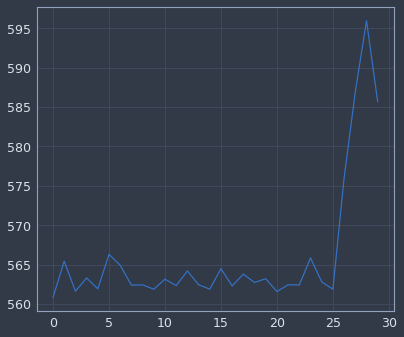

In [5]:
env_kwargs['n_envs'] = 512
env_kwargs['opponent'] = va.SavedRLAgent('a3c_agent_v2')
episode_reward_sums = a3c_alg.train(n_episodes=30, **rl_alg_kwargs, **env_kwargs)

#episode_reward_sums = a3c_vectorized_env(env, model, optimizer, n_episodes=50, **rl_alg_kwargs)
plt.plot(episode_reward_sums)
plt.show();
#plt.plot(episode_reward_sums);

100%|██████████| 30/30 [09:01<00:00, 18.06s/it]


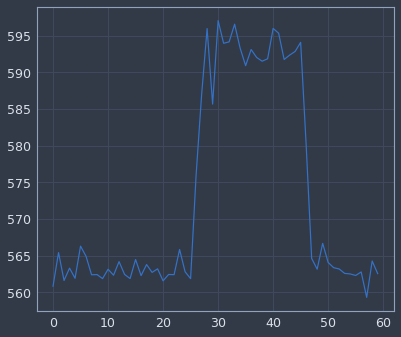

In [9]:
#env_kwargs['n_envs'] = 512
episode_reward_sums += a3c_alg.train(n_episodes=30, **rl_alg_kwargs, **env_kwargs)
plt.plot(episode_reward_sums)
plt.show();

In [94]:
temp_model = a3c_alg.model_constructor()
temp_model.load_state_dict(a3c_alg.checkpoints[78])
temp_model.to(device=DEVICE)
temp_model.eval();

def model_wrapped(states):
    return temp_model.sample_action(states.unsqueeze(0)).squeeze(0)
    #return a3c_alg.model.sample_action(states.unsqueeze(0)).squeeze(0)

In [95]:
#(a3c_alg.opp_a / (a3c_alg.opp_a + a3c_alg.opp_b)).argmax() - len(initial_opponent_pool)
est_opp_skill = a3c_alg.opp_a / (a3c_alg.opp_a + a3c_alg.opp_b)
ranking = np.argsort(-est_opp_skill)
idx = 2
print(f'Opponent {ranking[idx]}, ranked {idx+1}, has an estimated win % of {est_opp_skill[ranking[idx]]:.3f}.')
print(f'Checkpoint #{ranking[idx] - len(a3c_alg.initial_opponent_pool)}, path: {a3c_alg.exp_folder}/{(ranking[idx] - len(a3c_alg.initial_opponent_pool)) * a3c_alg.checkpoint_freq}_cp.txt')
#np.argsort(-est_opp_skill)
est_opp_skill

Opponent 79, ranked 3, has an estimated win % of 0.567.
Checkpoint #78, path: /home/isaiah/GitHub/Kaggle/Santa_2020/runs/v4_contd/780_cp.txt


array([0.50081914, 0.48598948, 0.51816986, 0.53534363, 0.46065866,
       0.44087082, 0.51414301, 0.51720425, 0.52793261, 0.47424356,
       0.42742923, 0.47529614, 0.5254527 , 0.48897261, 0.52109964,
       0.47694271, 0.45016783, 0.47601805, 0.47159289, 0.51855141,
       0.49580052, 0.51869415, 0.53858207, 0.536909  , 0.52732594,
       0.46640437, 0.45991462, 0.46329322, 0.45704959, 0.46743117,
       0.46791895, 0.53791149, 0.49548694, 0.48558865, 0.42920494,
       0.49406646, 0.49618068, 0.47742934, 0.43402368, 0.54164681,
       0.44940406, 0.50318364, 0.48262202, 0.49925114, 0.52893415,
       0.54877225, 0.53945825, 0.56086373, 0.54719396, 0.47510184,
       0.42878113, 0.54572381, 0.5094365 , 0.55278641, 0.54164065,
       0.52252991, 0.42326271, 0.47107882, 0.40678069, 0.50733141,
       0.48909083, 0.52528071, 0.44195002, 0.47717234, 0.44998456,
       0.46451931, 0.51163051, 0.43091032, 0.46783486, 0.49800934,
       0.4827651 , 0.52969608, 0.57089156, 0.50188092, 0.52136

## Benchmark the model against a previous RL agent, and various hand-crafted algorithms

In [10]:
a3c_alg.model.reset_hidden_states()
opp = va.SavedRLAgent('a3c_agent_v0')
#opp = va.BasicThompsonSampling(OBS_NORM)
va.run_vectorized_vs(model_wrapped, opp, 'new_model', 'opp', n_envs=1000, out_device=DEVICE, obs_type=ve.LAST_STEP_OBS, opponent_obs_type=ve.SUMMED_OBS)
a3c_alg.model.reset_hidden_states()

100%|██████████| 1999/1999 [00:12<00:00, 154.21it/s]


new_model -vs- opp
Mean scores: 566.30 - 653.99
Match score: 0 - 1 - 999 (0.0% - 0.1% - 99.9%)


In [11]:
va.run_vectorized_vs(va.RandomAgent(), va.SavedRLAgent('a3c_agent_v0'), '1', '2', n_envs=1000, out_device=DEVICE)

100%|██████████| 1999/1999 [00:04<00:00, 444.80it/s]


1 -vs- 2
Mean scores: 562.49 - 675.64
Match score: 0 - 0 - 1000 (0.0% - 0.0% - 100.0%)


In [14]:
test_env = ve.KaggleMABEnvTorchVectorized(**env_kwargs)
a3c_alg.model.reset_hidden_states()

In [15]:
s, _, _, _ = test_env.reset()
a = a3c_alg.model.sample_action(s.unsqueeze(0))

In [22]:
a3c_alg.model.get_hidden_states()[0][0][0][0,0]

tensor([ 0.0272,  0.0183,  0.0095,  0.0715, -0.0287,  0.0131,  0.0077, -0.0307,
        -0.0054, -0.0020,  0.0213, -0.0444, -0.0072,  0.0254, -0.0071,  0.0156],
       device='cuda:0')

In [96]:
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v3'), 'new_model', 'a3c_agent_v3', n_envs=4000, out_device=DEVICE)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v4-162'), 'new_model', 'a3c_agent_v4-162', n_envs=4000, out_device=DEVICE)

100%|██████████| 1999/1999 [00:46<00:00, 43.16it/s]


new_model -vs- a3c_agent_v3
Mean scores: 641.30 - 638.75
Match score: 2101 - 55 - 1844 (52.5% - 1.4% - 46.1%)


100%|██████████| 1999/1999 [00:48<00:00, 41.26it/s]


new_model -vs- a3c_agent_v4-162
Mean scores: 641.75 - 639.23
Match score: 2095 - 69 - 1836 (52.4% - 1.7% - 45.9%)


In [15]:
model.eval()
benchmark_env_kwargs = dict(
    n_envs=1000,
    out_device=DEVICE
)

## Against itself
va.run_vectorized_vs(model_wrapped, model_wrapped, 'new_model', 'new_model', **benchmark_env_kwargs)
#model_wrapped.reset_hidden_states()

## Previous best models
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v0'), 'new_model', 'a3c_agent_v0', **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v1'), 'new_model', 'a3c_agent_v1', **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v2'), 'new_model', 'a3c_agent_v2', **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v3'), 'new_model', 'a3c_agent_v3', n_envs=4000, out_device=DEVICE)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v4-162'), 'new_model', 'a3c_agent_v4-162', n_envs=4000, out_device=DEVICE)

## Always 0 agent
#va.run_vectorized_vs(model_wrapped, va.AlwaysFirstAgent(), 'new_model', 'always_first', **benchmark_env_kwargs)

## Random agent
#va.run_vectorized_vs(model_wrapped, va.RandomAgent(), 'new_model', 'random_agent', **benchmark_env_kwargs)

## Basic thompson sampling
va.run_vectorized_vs(model_wrapped, va.BasicThompsonSampling(OBS_NORM), 'new_model', 'basic_thompson_sampling', **benchmark_env_kwargs)

## Pull vegas slot machines
va.run_vectorized_vs(model_wrapped, va.PullVegasSlotMachines(OBS_NORM), 'new_model', 'pull_vegas_slot_machines', **benchmark_env_kwargs)

100%|██████████| 1999/1999 [00:08<00:00, 225.45it/s]


new_model -vs- new_model
Mean scores: 581.89 - 581.28
Match score: 502 - 18 - 480 (50.2% - 1.8% - 48.0%)


100%|██████████| 1999/1999 [00:08<00:00, 247.40it/s]


new_model -vs- a3c_agent_v0
Mean scores: 497.38 - 683.32
Match score: 0 - 0 - 1000 (0.0% - 0.0% - 100.0%)


100%|██████████| 1999/1999 [00:10<00:00, 197.35it/s]


new_model -vs- a3c_agent_v1
Mean scores: 505.32 - 672.76
Match score: 0 - 0 - 1000 (0.0% - 0.0% - 100.0%)


 15%|█▍        | 296/1999 [00:01<00:09, 172.20it/s]


KeyboardInterrupt: 

In [ ]:
temp_sd_checkpoint = model.state_dict()

## Visualize model parameter distributions

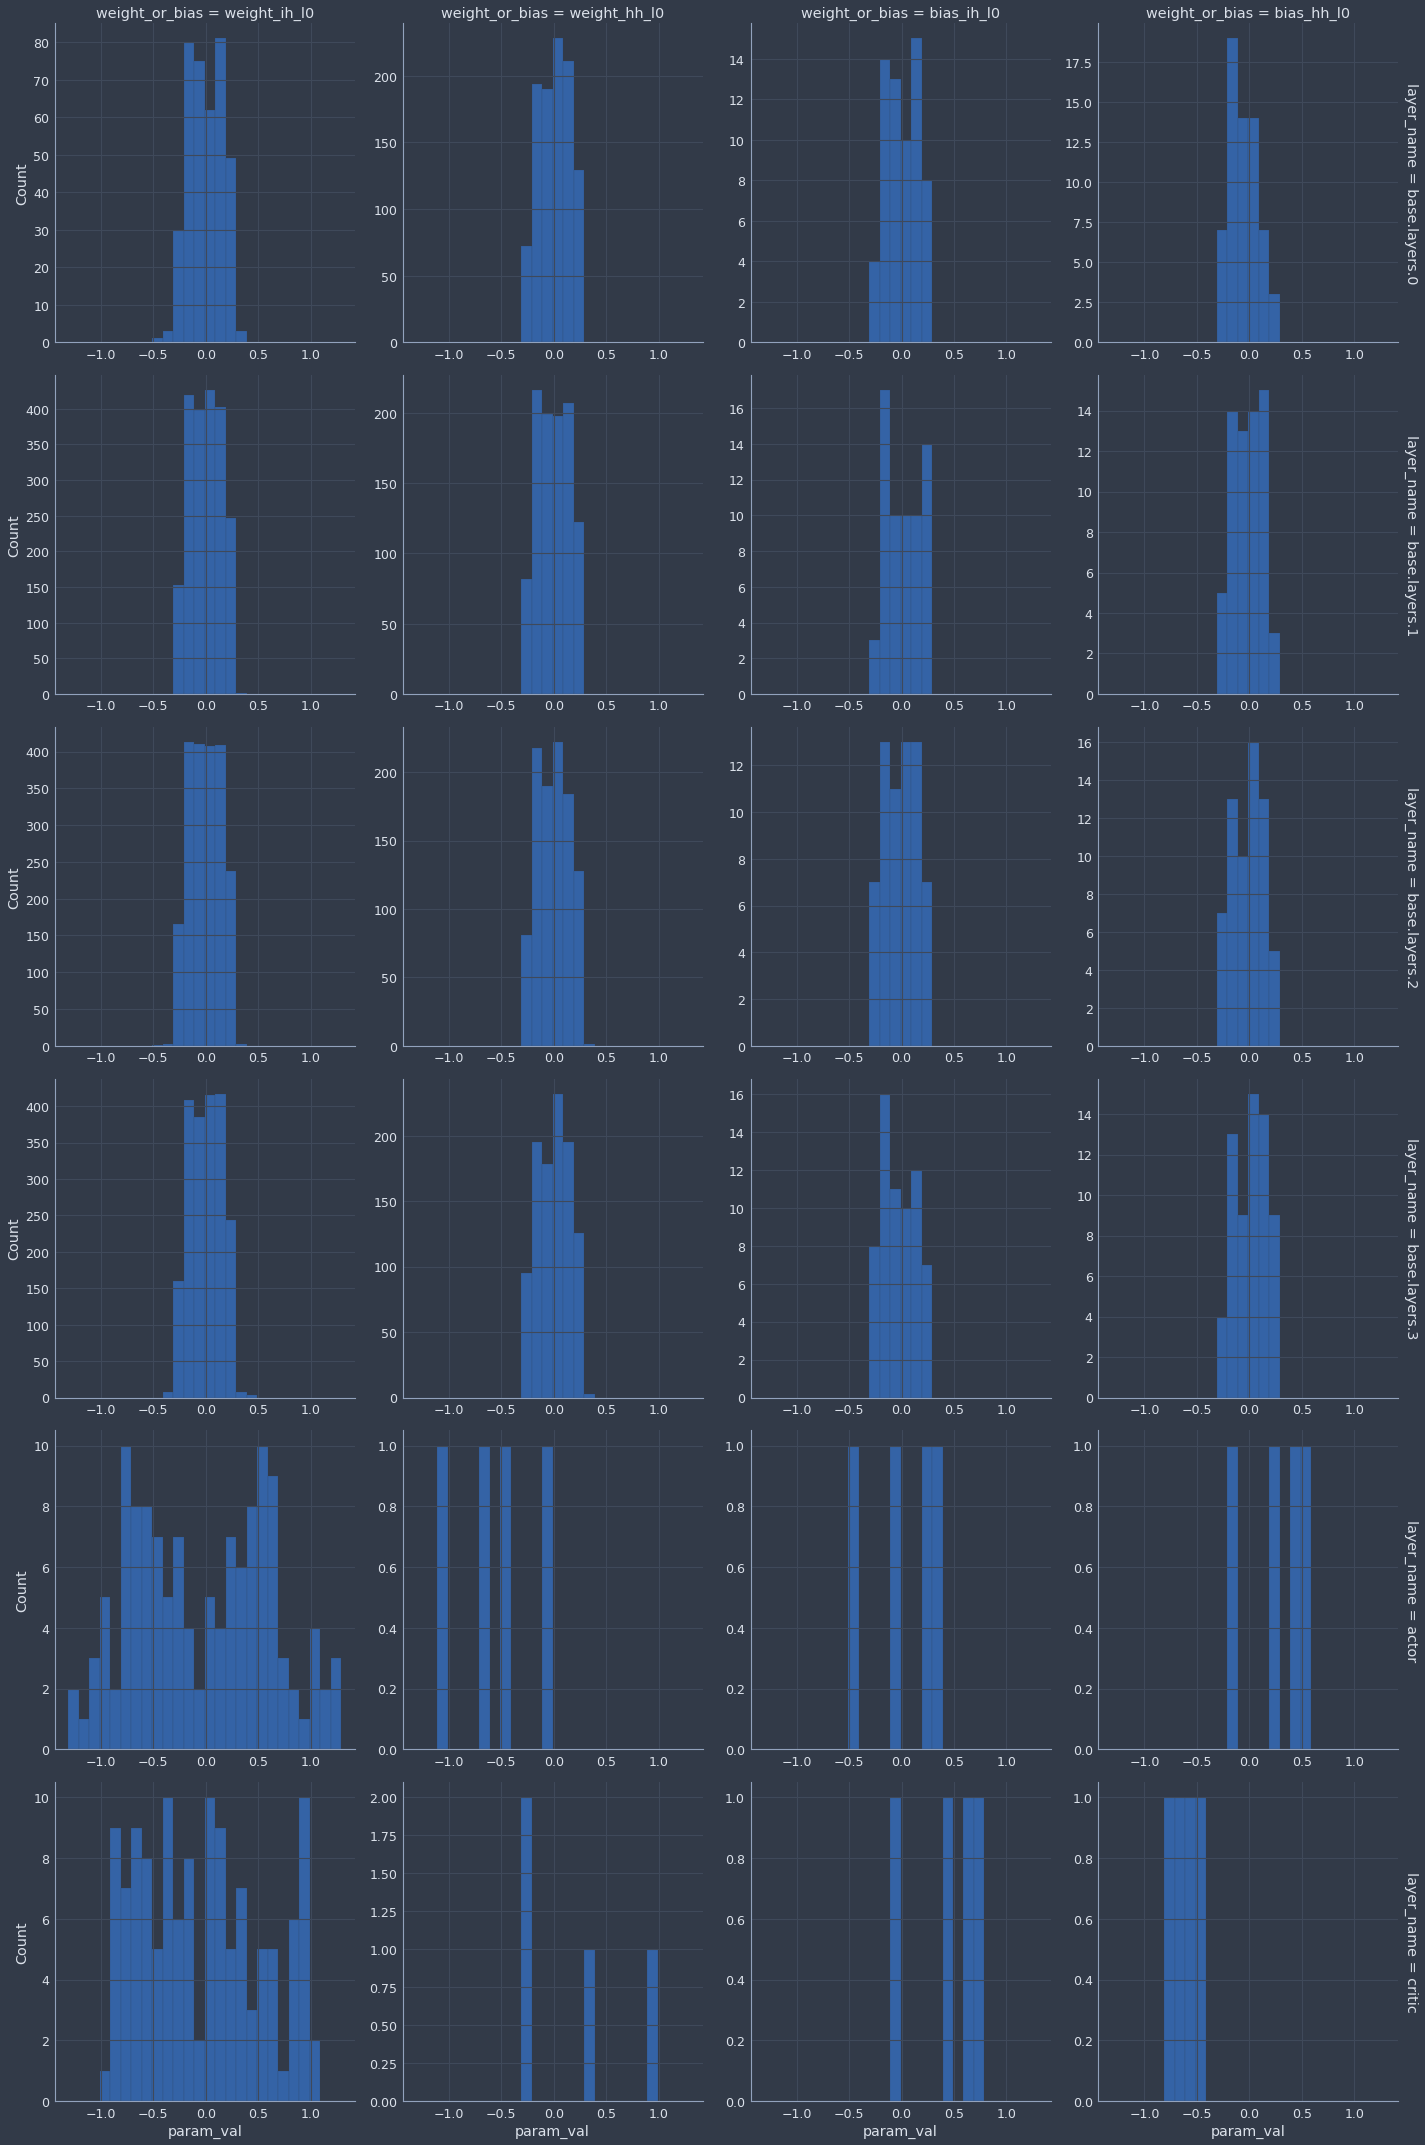

In [6]:
full_layer_name = []
layer_name = []
component_name = []
weight_or_bias = []
param_val = []
for key, val in model.state_dict().items():
    if 'message_passing_mat' in key:
        pass
    else:
        for v in val.cpu().numpy().ravel():
            param_val.append(v)
            full_layer_name.append(key)
            key_split = key.split('.')
            if len(key_split) == 3:
                ln, pn, wob = key_split
            elif len(key_split) >= 4:
                ln = '.'.join(key_split[0:-2])
                pn, wob = key_split[-2:]
            else:
                raise RuntimeError(f'Unrecognized layer key: {key}')
            layer_name.append(ln)
            component_name.append(pn)
            weight_or_bias.append(wob)
params_df = pd.DataFrame(dict(
    full_layer_name = full_layer_name,
    layer_name = layer_name,
    component_name = component_name,
    weight_or_bias = weight_or_bias,
    param_val = param_val
))

sns.displot(
    params_df, x='param_val', col='weight_or_bias', row='layer_name',
    binwidth=0.1,
    #height=3,
    facet_kws=dict(margin_titles=True, sharex=False, sharey=False)
);

In [29]:
params_df

,full_layer_name,layer_name,component_name,weight_or_bias,param_val
0,base.layers.0.recombine_features.weight_ih_l0,base.layers.0,recombine_features,weight_ih_l0,0.293951
1,base.layers.0.recombine_features.weight_ih_l0,base.layers.0,recombine_features,weight_ih_l0,0.093798
2,base.layers.0.recombine_features.weight_ih_l0,base.layers.0,recombine_features,weight_ih_l0,-0.065024
3,base.layers.0.recombine_features.weight_ih_l0,base.layers.0,recombine_features,weight_ih_l0,0.177684
4,base.layers.0.recombine_features.weight_ih_l0,base.layers.0,recombine_features,weight_ih_l0,-0.148650
...,...,...,...,...,...
11411,critic.recombine_features.bias_ih_l0,critic,recombine_features,bias_ih_l0,-1.058360
11412,critic.recombine_features.bias_hh_l0,critic,recombine_features,bias_hh_l0,-0.049016
11413,critic.recombine_features.bias_hh_l0,critic,recombine_features,bias_hh_l0,-0.446017
11414,critic.recombine_features.bias_hh_l0,critic,recombine_features,bias_hh_l0,0.037797


In [ ]:
full_layer_name = []
layer_name = []
component_name = []
weight_or_bias = []
param_val = []
for key, val in gnn.GraphNNA3C(**graph_nn_kwargs).state_dict().items():
    if 'message_passing_mat' in key:
        pass
    else:
        for v in val.cpu().numpy().ravel():
            param_val.append(v)
            full_layer_name.append(key)
            key_split = key.split('.')
            if len(key_split) == 3:
                ln, pn, wob = key_split
            elif len(key_split) >= 4:
                ln = '.'.join(key_split[0:-2])
                pn, wob = key_split[-2:]
            else:
                raise RuntimeError(f'Unrecognized layer key: {key}')
            layer_name.append(ln)
            component_name.append(pn)
            weight_or_bias.append(wob)
params_df = pd.DataFrame(dict(
    full_layer_name = full_layer_name,
    layer_name = layer_name,
    component_name = component_name,
    weight_or_bias = weight_or_bias,
    param_val = param_val
))

sns.displot(
    params_df, x='param_val', col='component_name', row='layer_name',
    binwidth=0.1,
    #height=3,
    facet_kws=dict(margin_titles=True, sharex=False, sharey=False)
);

## Save the model state_dict as a serialized string

In [27]:
model.to('cpu')
state_dict_bytes = pickle.dumps({
    'model_state_dict': model.state_dict(),
    #'optimizer_state_dict': optimizer.state_dict()
})
serialized_string = base64.b64encode(state_dict_bytes)
with open('rl_agents/ss_temp.txt', 'w') as f:
    f.write(str(serialized_string))
model.to(device=DEVICE);

## Testing and debugging

In [13]:
from scipy.stats import spearmanr, pearsonr

model.reset_hidden_states()
test_env = ve.KaggleMABEnvTorchVectorized(n_players=2, decay_rate=0.97, obs_type=ve.LAST_STEP_OBS)
with torch.no_grad():
    s, _, _, _ = test_env.reset()
    # Take n good actions
    for i in range(1):
        actions = test_env.thresholds.argmax(axis=-1)[:, None]
        s, _, _, _ = test_env.step(actions.repeat(1, test_env.n_players))
    logits, values = model(s[0,0].to(device=DEVICE)[None, None, :])
    logits = logits.cpu().numpy().squeeze()
    values = values.cpu().numpy().squeeze()
print()
print(logits)
print(values)
print(s[:,0].squeeze().t())
print(spearmanr(logits, test_env.thresholds.squeeze().cpu().numpy())[0],
      pearsonr(logits, test_env.thresholds.squeeze().cpu().numpy())[0])


[-0.3799582  -0.3799582  -0.37995818 -0.37995818 -0.37995818 -0.37995815
 -0.37995818 -0.37995815 -0.37995818 -0.37995818 -0.3799582  -0.37995818
 -0.3799582  -0.37995818 -0.3799582  -0.37995818 -0.3799582  -0.3799582
 -0.37995818 -0.37995818 -0.37995818 -0.37995815 -0.37995818 -0.37995815
 -0.37995818 -0.37995818 -0.3799582  -0.37995818 -0.3799582  -0.37995818
 -0.3799582  -0.37995818 -0.3799582  -0.3799582  -0.37995818 -0.37995818
 -0.37995818 -0.37995815 -0.37995818 -0.37995815 -0.37995818 -0.37995818
  0.71257406 -0.37995818 -0.3799582  -0.37995818 -0.3799582  -0.37995818
 -0.3799582  -0.3799582  -0.37995818 -0.37995818 -0.37995818 -0.37995815
 -0.37995818 -0.37995815 -0.37995818 -0.37995818 -0.3799582  -0.37995818
 -0.3799582  -0.37995818 -0.3799582  -0.37995818 -0.3799582  -0.3799582
 -0.37995818 -0.37995818 -0.37995818 -0.37995815 -0.37995818 -0.37995815
 -0.37995818 -0.37995818 -0.3799582  -0.37995818 -0.3799582  -0.37995818
 -0.3799582  -0.37995818 -0.3799582  -0.3799582  -0.

In [ ]:
child_layer_idx = -1
child_layer = list(model.children())[child_layer_idx]
print(child_layer.transform_features.weight.data, child_layer.transform_features.bias.data)
print(child_layer.recombine_features.weight.data, child_layer.recombine_features.bias.data)
print(model)
print(child_layer)

In [ ]:
test_env = ve.KaggleMABEnvTorchVectorized(n_envs=3, n_players=2, decay_rate=0.97, env_device=torch.device('cpu'), out_device=DEVICE)
test_env.reset()
actions = torch.arange(6).view(3,2)
test_env.step(actions)
test_env.step(actions)
actions = torch.arange(1,7).view(3,2)
test_env.step(actions)
test_env.step(actions)
test_env.step(actions)

test = test_env.player_n_pulls.unsqueeze(3).expand(-1,-1,-1,2).transpose(1,3)
test = torch.cat([
    test[:,0,:,:].unsqueeze(1),
    test[:,0,:,[1,0]].unsqueeze(1)
], dim=1)
test[0,0]
test_env.player_rewards_sums

In [ ]:
# Simulated env rollouts with random policy
test_env = ve.KaggleMABEnvTorchVectorized(n_envs=1000, n_players=2, decay_rate=0.97, env_device=torch.device('cuda'), out_device=torch.device('cuda'))

for i in tqdm.trange(test_env.n_steps):
    actions = torch.randint(test_env.n_bandits, size=(test_env.n_envs, test_env.n_players))
    test_env.step(actions)
print(f'Mean of player rewards: {test_env.player_rewards_sums.sum(axis=-1).mean():.2f}, Standard deviation of player rewards: {test_env.player_rewards_sums.sum(axis=-1).std():.2f}')

In [ ]:
# Simulated env rollouts with omniscient optimal policy
test_env = ve.KaggleMABEnvTorchVectorized(n_envs=1000, n_players=2, decay_rate=0.97, env_device=torch.device('cuda'), out_device=torch.device('cpu'))

for i in tqdm.trange(test_env.n_steps):
    actions = test_env.thresholds.argmax(axis=-1)[:, None]
    test_env.step(actions.repeat(1, test_env.n_players))
print(f'Mean of player rewards: {test_env.player_rewards_sums.sum(axis=-1).mean():.2f}, Standard deviation of player rewards: {test_env.player_rewards_sums.sum(axis=-1).std():.2f}')

In [ ]:
n_nodes = 10
activation_func = nn.ReLU()
layer_size = 64
layers = (
    [FullyConnectedGNNLayer(n_nodes, 1, layer_size, activation_func=activation_func)] +
    [FullyConnectedGNNLayer(n_nodes, layer_size, layer_size, activation_func=activation_func)] * 0 +
    [FullyConnectedGNNLayer(n_nodes, layer_size, 1, activation_func=activation_func)]
)
model = nn.Sequential(
    *layers
)
#model = FullyConnectedGNNLayer(n_nodes, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for i in tqdm.trange(10):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

test_batch_in = torch.rand((1, n_nodes, 1), dtype=torch.float).to('cuda')
print(test_batch_in)
print(F.softmax(model(test_batch_in), dim=1))
print(torch.topk(test_batch_in, k=k, dim=1).indices[:,k-1])
print(F.softmax(model(test_batch_in), dim=1).argmax(dim=1))

In [ ]:
for i in tqdm.trange(1000):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

In [ ]:
model = FullyConnectedGNNLayer(5, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.)

for i in tqdm.trange(10000):
    train_batch_in = torch.rand((1024, 5, 1), dtype=torch.float).to('cuda')
    train_batch_out = train_batch_in + train_batch_in.sum(dim=1, keepdims=True)
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, train_batch_out)
    loss.backward()
    optimizer.step()
loss

In [ ]:
train_batch_in = torch.rand((2, 5, 1), dtype=torch.float).to('cuda')
print(train_batch_in)
print(train_batch_in + train_batch_in.sum(dim=1, keepdims=True))
print(model(train_batch_in))

## Deprecated

In [ ]:
# Loosely based on: https://github.com/MorvanZhou/pytorch-A3C
def a3c_vectorized_env(env, model, optimizer, n_episodes, batch_size,
                       gamma=0.9):
    model.to(device=DEVICE)
    model.train()
    episode_reward_sums = []
    
    for episode in tqdm.trange(n_episodes):
        buffer_s, buffer_a, buffer_r = [], [], []
        s, r, _, _ = env.reset()
        episode_reward_sums.append(r)
        step_count = 1
        while not env.done:
            # Batch size of 1 for inference
            a = model.sample_action(s.to(device=DEVICE).unsqueeze(0)).squeeze(0)
            next_s, r, done, _ = env.step(a)
            
            #print(s.shape, a.shape, r.shape)
            buffer_s.append(s)
            buffer_a.append(a)
            buffer_r.append(r)
            
            if step_count % batch_size == 0 or done:
                if done:
                    v_next_s = torch.zeros_like(buffer_r[-1])
                else:
                    _, v_next_s = model(next_s.to(device=DEVICE).unsqueeze(0))
                    v_next_s = v_next_s.detach().squeeze(0)
                v_next_s.to(device=DEVICE)
                
                buffer_v_target = []
                for r in buffer_r[::-1]:
                    v_next_s = r + gamma * v_next_s
                    buffer_v_target.append(v_next_s)
                buffer_v_target.reverse()
                
                loss = model.loss_func(
                    torch.stack(buffer_s).to(device=DEVICE),
                    torch.stack(buffer_a).to(device=DEVICE),
                    torch.stack(buffer_v_target).to(device=DEVICE)
                )
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                buffer_s, buffer_a, buffer_r = [], [], []
            s = next_s
            episode_reward_sums[-1] += r
            step_count += 1
        episode_reward_sums[-1] = episode_reward_sums[-1].mean()
    return episode_reward_sums

In [ ]:
class Kaggle_MAB_Env_Numpy_Vectorized():
    def __init__(self,
                 # Kaggle MAB env params
                 n_bandits=100, n_steps=1999, decay_rate=0.97, sample_resolution=100,
                 # Custom params
                 n_envs=1, n_players=2, reward_type=EVERY_STEP, remove_extra_dims=False):
        # Assert parameter conditions
        assert 0 <= decay_rate <= 1.
        assert reward_type in (END_OF_GAME, EVERY_STEP)
        if reward_type == END_OF_GAME:
            assert n_players >= 2
        else:
            assert n_players >= 1
        self.n_bandits = n_bandits
        self.n_steps = n_steps
        self.decay_rate = decay_rate
        self.sample_resolution = sample_resolution
        
        self.n_envs = n_envs
        self.n_players = n_players
        self.reward_type = reward_type
        self.remove_extra_dims = remove_extra_dims
        
        self.timestep = None
        self.orig_thresholds = None
        self.player_n_pulls = None
        self.player_rewards_sums = None
        self.reset()
    
    @property
    def thresholds(self):
        return self.orig_thresholds * (self.decay_rate ** self.player_n_pulls[:,0,:])
    
    def reset(self):
        self.timestep = 0
        self.orig_thresholds = np.random.randint(self.sample_resolution + 1, size=(self.n_envs, self.n_bandits)).astype(np.float32)
        self.player_n_pulls = np.zeros((self.n_envs, self.n_players, self.n_bandits))
        self.player_rewards_sums = np.zeros_like(self.player_n_pulls)
        
        rewards = np.zeros((self.n_envs, self.n_players))
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
        
    def step(self, actions):
        if self.remove_extra_dims:
            if type(actions) == int:
                actions = np.array([[actions]])
            else:
                actions = actions.reshape((self.n_envs, self.n_players))
        assert actions.shape == (self.n_envs, self.n_players), f'actions.shape was: {actions.shape}'
        assert not self.done
        self.timestep += 1
        
        # Compute agent rewards
        selected_thresholds = np.take_along_axis(self.thresholds, actions, axis=1)
        pull_rewards = np.random.randint(self.sample_resolution, size=selected_thresholds.shape) < selected_thresholds
        #pull_rewards = selected_thresholds / float(self.sample_resolution)
        
        # Update player_n_pulls and player_rewards_sums
        for env_idx, env_actions in enumerate(actions):
            for player_idx, pull_idx in enumerate(env_actions):
                self.player_n_pulls[env_idx, :, pull_idx] += 1
                self.player_rewards_sums[env_idx, player_idx, pull_idx] += pull_rewards[env_idx, player_idx]
        
        # Return (obs, reward, done) tuple
        if self.reward_type == END_OF_GAME:
            rewards = np.zeros_like(actions)
            if self.timestep == self.n_steps:
                rewards_sums = self.player_rewards_sums.sum(axis=2)
                winners = rewards_sums.argmax(axis=1)
                rewards[winners] = 1
        elif self.reward_type == EVERY_STEP:
            rewards = pull_rewards
        
        # State, reward, done, info_dict
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
    
    def get_obs(self):
        # TODO: Clearly do not return thresholds or orig_thresholds
        return np.stack([
            #np.broadcast_to(self.orig_thresholds[:, None, :] / self.sample_resolution, self.player_n_pulls.shape),
            self.player_n_pulls,
            self.player_rewards_sums
        ], axis=-1).astype(np.float32)
    
    @property
    def done(self):
        return self.timestep >= self.n_steps

In [5]:
class FeedForwardNN_A3C(nn.Module):
    def __init__(self, in_features, n_bandits, activation_func=nn.ReLU()):
        super().__init__()
        self.in_features = in_features
        self.activation_func = activation_func
        layer_size = 128
        self.base = nn.Sequential(
            nn.Linear(self.in_features, layer_size),
            activation_func,
            nn.Linear(layer_size, layer_size),
            activation_func,
        )
        self.actor = nn.Linear(layer_size, n_bandits)
        self.critic = nn.Linear(layer_size, 1)
        
    def forward(self, states):
        in_shape = states.shape
        base_out = self.base(states.view(-1, self.in_features))
        return self.activation_func(self.actor(base_out)).view(in_shape[:-1]), self.critic(base_out).view(in_shape[:-2])
    
    def sample_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            probs = F.softmax(logits, dim=-1)
            batch_size, n_envs, n_players, n_bandits = probs.shape
            m = distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
            return m.sample().view(batch_size, n_envs, n_players)
    
    def choose_best_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            return logits.argmax(dim=-1)
        
    def loss_func(self, states, actions, v_t):
        #print(f'states.shape: {states.shape}, actions.shape: {actions.shape}, v_t.shape: {v_t.shape}')
        logits, values = self.forward(states)
        
        #print(f'logits.shape: {logits.shape}, values.shape: {values.shape}')
        td = v_t - values
        critic_loss = td.pow(2).view(-1)
        
        probs = F.softmax(logits, dim=-1)
        batch_size, n_envs, n_players, n_bandits = probs.shape
        m = distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
        #print(f'm.log_prob(actions.view(batch_size * n_envs * n_players)).shape: {m.log_prob(actions.view(batch_size * n_envs * n_players)).shape}, td.shape: {td.shape}')
        actor_loss = -(m.log_prob(actions.view(-1)) * td.detach().view(-1))
        total_loss = (critic_loss + actor_loss).mean()
        return total_loss